# Iris classification

This notebook will walk through the process of using the ITEA for classification (``ITEA_classifier``) and interpreting the final expression with the ``itea.inspection`` tools.

In [1]:
import numpy  as np
import pandas as pd

# automatically differentiable implementation of numpy
import jax.numpy as jnp # v0.2.13

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from IPython.display         import display, Latex

from itea.classification import ITEA_classifier
from itea.inspection     import *

import warnings
warnings.filterwarnings(action='ignore', module=r'itea')

We will use the Iris data set in this example.

This data set contains 3 different classes of Iris flowers and has 4 features: sepal width, sepal length, petal width, and petal length.

One example of each flower is illustrated in the figure below.

![](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Machine+Learning+R/iris-machinelearning.png)

## Creating and fitting an ``ITEA_classifier``

In this execution, we will fix the random_state argument to allow reproductible executions of the ITEA algorithm.

The IT expression is used as the decision function in a logistic regression. The inner logistic regression uses the saga solver described in _"Defazio, A., Bach F. & Lacoste-Julien S. (2014). SAGA: A Fast Incremental Gradient Method With Support for Non-Strongly Convex Composite Objectives"_.

The method will solve a **multinomial** classification problem with the softmax funcion applied over the decision function. By default, no regularization os performed (although the user can controlate this by setting values to alpha and beta parameters), and a maximum of 100 iterations of the saga solver is performed for each expression.

In [2]:
iris_data = datasets.load_iris()
X, y      = iris_data['data'], iris_data['target']
labels    = iris_data['feature_names']
targets   = iris_data['target_names']

# changing numbers to the class names
y_targets = [targets[yi] for yi in y]

X_train, X_test, y_train, y_test = train_test_split(
    X, y_targets, test_size=0.33, random_state=42)

# Creating transformation functions for ITEA using jax.numpy
# (so we don't need to analytically calculate its derivatives)
tfuncs = {
    'id'       : lambda x: x,
    'sqrt.abs' : lambda x: jnp.sqrt(jnp.abs(x)), 
    'log'      : jnp.log,
    'exp'      : jnp.exp
}

clf = ITEA_classifier(
    gens            = 50,
    popsize         = 50,
    max_terms       = 2,
    expolim         = (-1, 1),
    verbose         = 5,
    tfuncs          = tfuncs,
    labels          = labels,
    simplify_method = 'simplify_by_var',
    fit_kw          = {'max_iter':100},
    random_state    = 42,
).fit(X_train, y_train)

gen | smallest fitness | mean fitness | highest fitness | remaining time
----------------------------------------------------------------------------
  0 |         0.560000 |     0.848200 |        0.970000 | 0min20sec   
  5 |         0.740000 |     0.961800 |        0.980000 | 0min14sec   
 10 |         0.790000 |     0.969400 |        0.990000 | 0min15sec   
 15 |         0.950000 |     0.982200 |        0.990000 | 0min10sec   
 20 |         0.890000 |     0.982200 |        0.990000 | 0min10sec   
 25 |         0.860000 |     0.982400 |        0.990000 | 0min9sec    
 30 |         0.930000 |     0.981800 |        0.990000 | 0min12sec   
 35 |         0.960000 |     0.982600 |        0.990000 | 0min10sec   
 40 |         0.940000 |     0.981600 |        0.990000 | 0min5sec    
 45 |         0.660000 |     0.973800 |        0.990000 | 0min2sec    


Since the ``ITEA_classifier`` and the best solution found by the ITEA ``ITExpr_classifier`` are both scikit-like models, we can use some base methods like ``get_params``.

In the cell below we inspect the parameters of the best expression. We can see the logistic regression regularization parameters (alpha and beta), the maximum number of iterations of the coefficients adjustment algorithm (max_iter), and the array of IT terms (expr), containing the terms that are being used to create the decision function for the logistic regression.

In [3]:
# clf.get_params()          returns the ITEA parameters
# clf.bestsol_.get_params() returns the best expression parameters

clf.bestsol_.get_params()

{'alpha': 0.0,
 'beta': 0.0,
 'expr': [('id', [0, -1, 1, 1]), ('id', [1, -1, -1, 0])],
 'labels': array(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
        'petal width (cm)'], dtype='<U17'),
 'max_iter': 100,
 'tfuncs': {'id': <function __main__.<lambda>(x)>,
  'sqrt.abs': <function __main__.<lambda>(x)>,
  'log': <function jax._src.numpy.lax_numpy._one_to_one_unop.<locals>.<lambda>(x)>,
  'exp': <function jax._src.numpy.lax_numpy._one_to_one_unop.<locals>.<lambda>(x)>}}

## Inspecting the results from ``ITEA_classifier`` and ``ITExpr_classifier``

Now that we have fitted the ITEA, our ``clf`` contains the ``bestsol_`` attribute, which is a fitted instance of ``ITExpr_classifier`` ready to be used.

In [4]:
final_itexpr = clf.bestsol_

final_itexpr.to_str(term_separator='\n')

'[-5.254  0.243  5.012]*id(sepal width (cm)^-1 * petal length (cm) * petal width (cm))\n[ 5.245  0.224 -5.469]*id(sepal length (cm) * sepal width (cm)^-1 * petal length (cm)^-1)\n[ 4.124  3.503 -7.627]'

In [5]:
print(classification_report(
    y_test,
    final_itexpr.predict(X_test),
    target_names=targets
))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        19
  versicolor       0.94      1.00      0.97        15
   virginica       1.00      0.94      0.97        16

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



We can use the ``ITExpr_inspector`` to obtain metrics regarding the IT terms in the expression

In [6]:
display(pd.DataFrame(
    ITExpr_inspector(
        itexpr=final_itexpr, tfuncs=tfuncs
    ).fit(X_train, y_train).terms_analysis()
))

,coef,func,strengths,coef\nstderr.,mean pairwise\ndisentanglement,mean mutual\ninformation,prediction\nvar.
0,[-5.254 0.243 5.012],id,"[0, -1, 1, 1]",[3.978 1.134 1.431],0.766,0.905,[63.693 0.136 57.947]
1,[ 5.245 0.224 -5.469],id,"[1, -1, -1, 0]",[14.394 7.012 10.91 ],0.766,0.905,[2.26 0.004 2.458]
2,[ 4.124 3.503 -7.627],intercept,---,[13.579 6.165 7.181],0.000,0.000,[0. 0. 0.]


By using the ``ITExpr_texifier``, we can create formatted LaTeX strings of the final expression and its derivatives.

In [7]:
# The final expression
display(Latex(
    '$ ITExpr = ' + ITExpr_texifier.to_latex(
        final_itexpr,
        term_wrapper=lambda i, term: r'\underbrace{' + term + r'}_{\text{term ' + str(i) + '}}'
    ) + '$'
))

<IPython.core.display.Latex object>

In [8]:
# List containing the partial derivatives
derivatives_latex = ITExpr_texifier.derivatives_to_latex(
    final_itexpr,
    term_wrapper=lambda i, term: r'\underbrace{' + term + r'}_{\text{term ' + str(i) + r' partial derivative}}'
)

# displaying one of its derivatives
display(Latex(
    r'$ \frac{\partial}{\partial ' + labels[0] + '} ITExpr = ' + derivatives_latex[0] + '$'
))

<IPython.core.display.Latex object>

## Explaining the ``IT_classifier`` expression using Partial Effects

Now let's create an instance of ``ITExpr_explainer``.

We can calculate feature importances with Partial Effects (PE) or approximate the Shapley values using PE. There is also support to use Integrated Gradients as a feature importance method.

In [9]:
# First lets create and fit the explainer with training data

explainer = ITExpr_explainer(
    itexpr=final_itexpr,
    tfuncs=tfuncs
).fit(X_train, y_train)

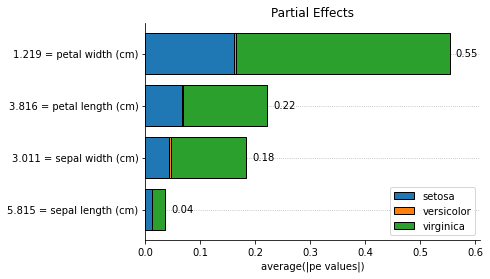

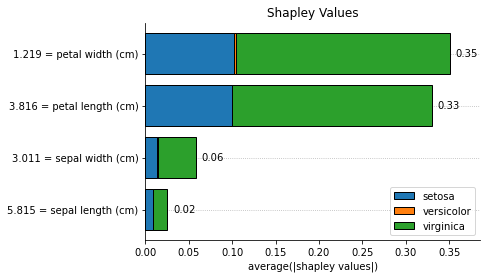

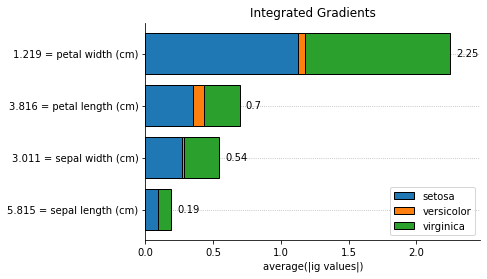

In [10]:
for method, method_name in [
    ('pe',      'Partial Effects'),
    ('shapley', 'Shapley Values'),
    ('ig',      'Integrated Gradients')
]:
    explainer.plot_feature_importances(
        X = X_train,
        importance_method = method,
        grouping_threshold = 0.0,
        target = None,
        barh_kw = {'edgecolor' : 'k'},
        show = False
    )
    
    # when we call a plot function, the explainers' axes_
    # will be the axes of the last plot. we called the plot function
    # with show=False to access the plot to add a title and then
    # we explicitly used the show() method to display the plots
    explainer.axes_.set_title(method_name)
    plt.show()

We can explain a single instance as well:

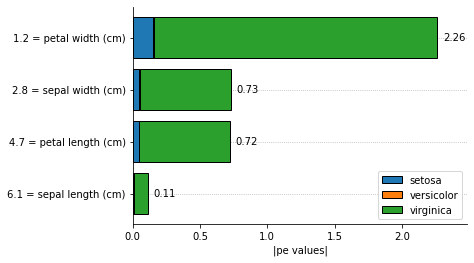

In [11]:
explainer.plot_feature_importances(
    X = X_test[0, :].reshape(1, -1),
    importance_method = 'pe', # change to 'shapley'
    grouping_threshold = 0.0,
    target = None,
    barh_kw = {'edgecolor' : 'k'},
    show = True
)

Instead of looking into the average Partial Effects, we can plot the Partial Effects for each variable when its co-variables are fixed at the means.

One phenomenon that can occur in a multiclassification problem is to have one class being a baseline, which is observed below. This explains why the feature importance shoud be summed for all classes.

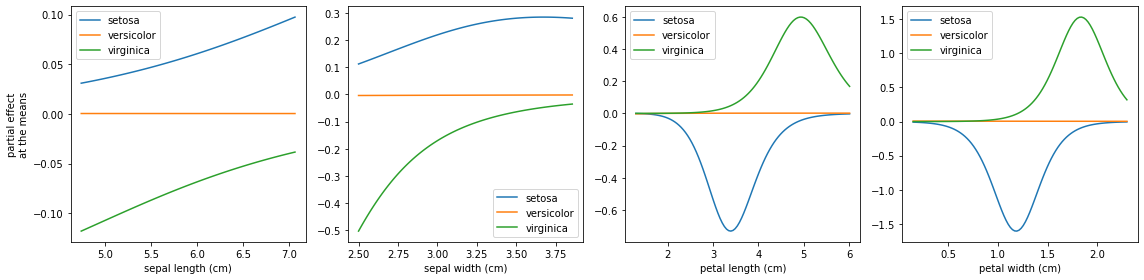

In [12]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

explainer.plot_partial_effects_at_means(
    X          = X_test, # Obtaining explanations for test data 
    ax         = axs,
    features   = final_itexpr.labels,
    target     = None,
    num_points = 100,
    share_y    = False,
    show_err   = False,
    show       = False,
)

plt.tight_layout()
plt.show()

We can share the y axis and show errors hatchs:

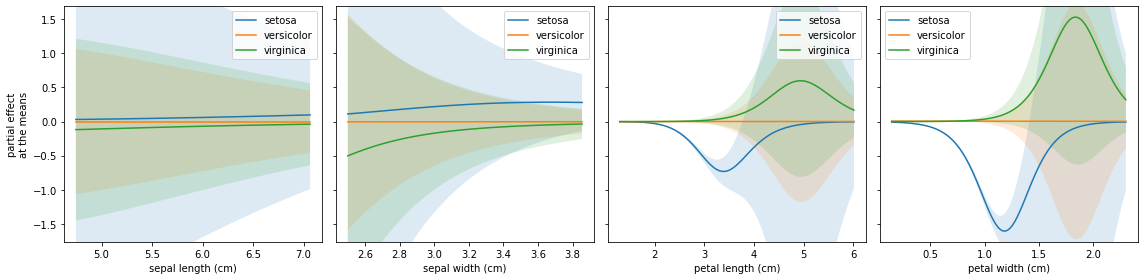

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

explainer.plot_partial_effects_at_means(
    X          = X_test, # Obtaining explanations for test data 
    ax         = axs,
    features   = final_itexpr.labels,
    target     = None,
    num_points = 100,
    share_y    = True,
    show_err   = True,
    show       = False,
)

plt.tight_layout()
plt.show()

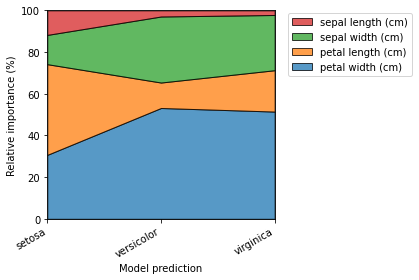

In [14]:
explainer.plot_normalized_partial_effects(grouping_threshold=0.1, show=False)

plt.tight_layout()
plt.show()